In [2]:
# load required libraries: you may need to install netCDF4
from defaults import *
%matplotlib notebook

data directory /media/martin/Projects/QA4ECV_ATBD-master/data


In [3]:
# load up the datasets we want
# 
# Mostly, this is the Ab data at this point
# but we will also load v3.0 or v2.0 data for support
#

datakeys = np.array(['bbdr.meris', 'bbdr.vgt', 'ga.brdf.merge',\
       'ga.brdf.nosnow', 'ga.brdf.snow', 'mod09', 'myd09',\
       'prior.v2.nosnow', 'prior.v2.snow', 'prior.v2.snownosnow'])

# load the datasets into a dictionary in ncdata
ncdata = {}
abdata = {}
for k in datakeys:
    try:
        abdata[k] = load_obj('obj/' + k + '_Ab_' )
        print '\nAb',k,
    except:
        pass
    try:
        ncdata[k] = load_obj('obj/' + k + '_s3.0_' )
        print '\n\t3',k,
    except:
        ncdata[k] = load_obj('obj/' + k + '_s2.0_' )
        print '\n\t\t2',k,
        
        
nbands,nk = ncdata['mod09']['kernels'].shape[0:2]
nskip = nbands *nk


Ab bbdr.meris 
	3 bbdr.meris 
Ab bbdr.vgt 
	3 bbdr.vgt 
		2 ga.brdf.merge 
		2 ga.brdf.nosnow 
		2 ga.brdf.snow 
Ab mod09 
	3 mod09 
Ab myd09 
	3 myd09 
Ab prior.v2.nosnow 
		2 prior.v2.nosnow 
Ab prior.v2.snow 
		2 prior.v2.snow 
		2 prior.v2.snownosnow


In [4]:
print 'Ab data available for',abdata.keys()
print
print 'The keys inside Ab data:',abdata['mod09'].keys()

Ab data available for ['myd09', 'bbdr.vgt', 'prior.v2.snow', 'mod09', 'prior.v2.nosnow', 'bbdr.meris']

The keys inside Ab data: ['A', 'b', 'd0', 'doys']


SHAPE OF xx (3, 9)
myd09 SHAPE OF k (239, 9)


<IPython.core.display.Javascript object>


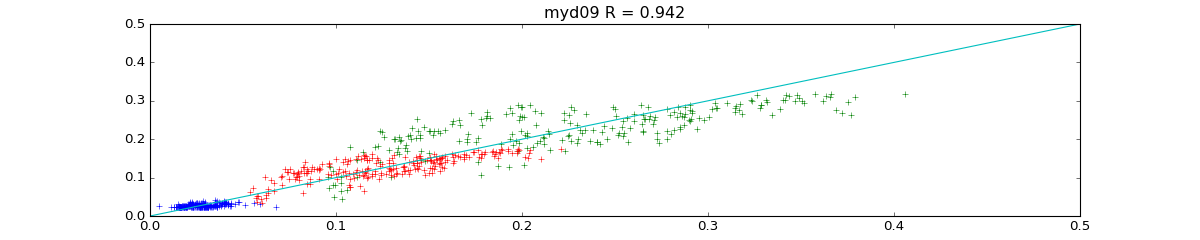

SHAPE OF YHAT (239, 3)
LinregressResult(slope=0.88793815084521643, intercept=0.01422416869928711, rvalue=0.94230470169961811, pvalue=0.0, stderr=0.011796881839926212)


<IPython.core.display.Javascript object>


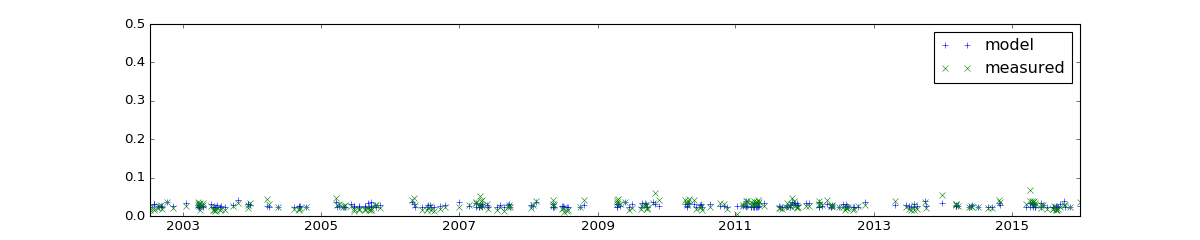


SHAPE OF xx (3, 9)
bbdr.vgt SHAPE OF k (790, 9)


<IPython.core.display.Javascript object>


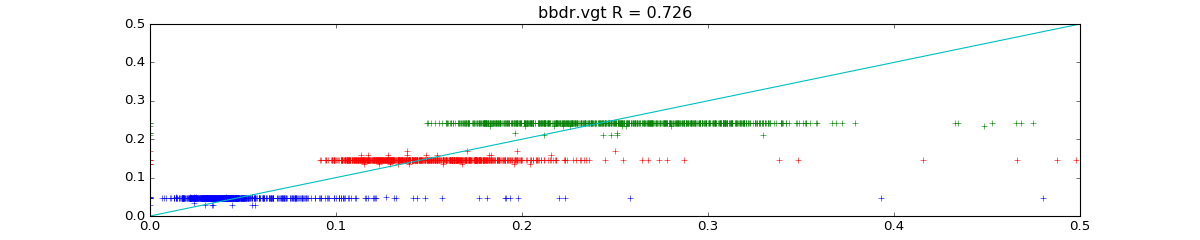

SHAPE OF YHAT (790, 3)
LinregressResult(slope=0.52543179461809986, intercept=0.062895423099837214, rvalue=0.72603567358554633, pvalue=0.0, stderr=0.010226792199119079)


<IPython.core.display.Javascript object>


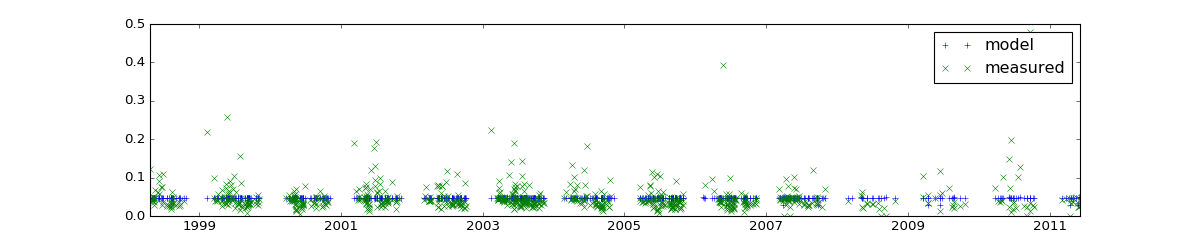


SHAPE OF xx (3, 9)
prior.v2.snow
SHAPE OF xx (3, 9)
mod09 SHAPE OF k (722, 9)


<IPython.core.display.Javascript object>


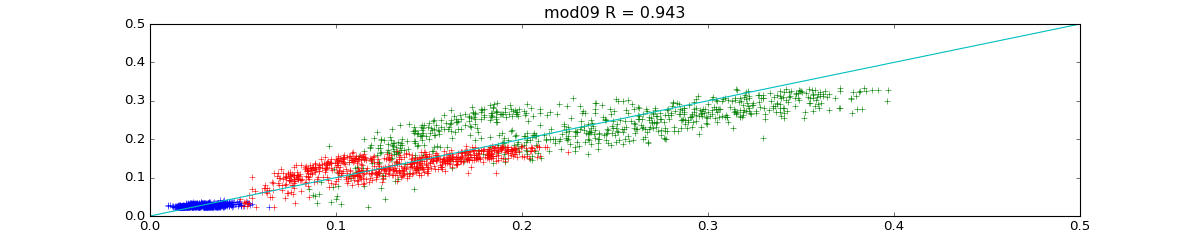

SHAPE OF YHAT (722, 3)
LinregressResult(slope=0.8900286384494478, intercept=0.014484037909454892, rvalue=0.94341329143142849, pvalue=0.0, stderr=0.0067253232504558566)


<IPython.core.display.Javascript object>


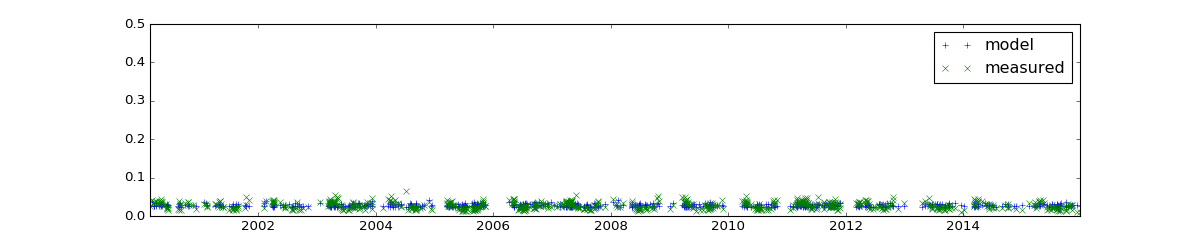


SHAPE OF xx (3, 9)
prior.v2.nosnow
SHAPE OF xx (3, 9)
bbdr.meris SHAPE OF k (341, 9)


<IPython.core.display.Javascript object>


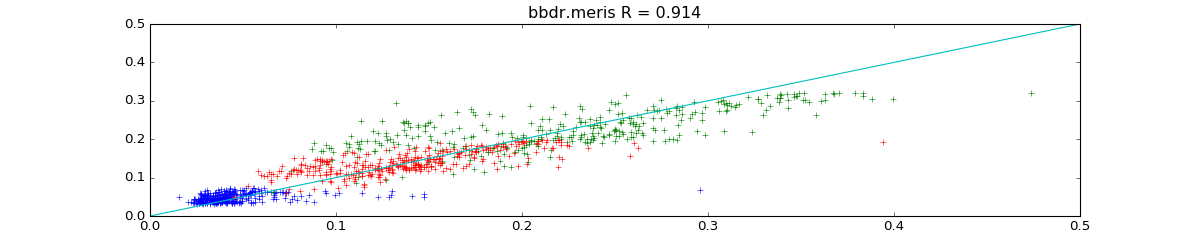

SHAPE OF YHAT (341, 3)
LinregressResult(slope=0.82101910957050794, intercept=0.02631111868493774, rvalue=0.91365193607452722, pvalue=0.0, stderr=0.01143187303614657)


<IPython.core.display.Javascript object>


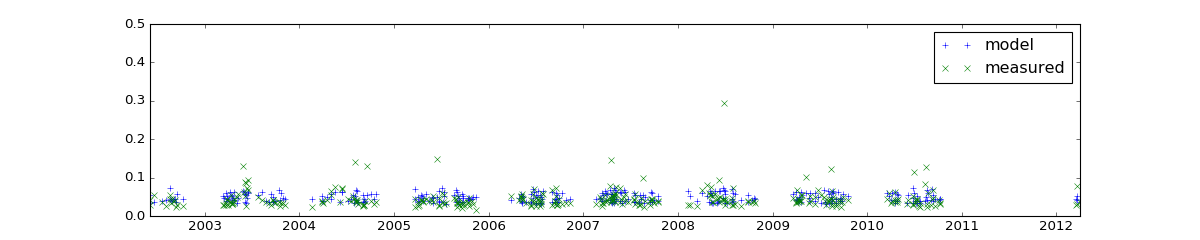

In [10]:
def subblock(A,i,j=None,nskip=9):
    '''
    Pull subblock i (,j) from A
    '''
    sli = slice(i*nskip,(i+1)*nskip)
    if A.shape[1] == 1:
        try:
            return A[sli,0].todense()
        except:
            return A[sli,0]
    if j == None: j = i
    slj = slice(j*nskip,(j+1)*nskip)
    try:
        return A[sli,slj].todense()
    except:
        return A[sli,slj]


# solve for each observation dataset, assuming constant over time
for sensor in abdata.keys():
    A,b,d0 = abdata[sensor]['A'],abdata[sensor]['b'],abdata[sensor]['d0']
    Ablocks = np.array([subblock(A,i) for i in xrange(A.shape[0]/nskip)])
    # shape is eg (6483, 9, 9)
    bblocks = np.array([subblock(b,i) for i in xrange(A.shape[0]/nskip)])
    # shape is eg (6483, 9, 1)
    A = Ablocks.sum(axis=0)
    b = bblocks.sum(axis=0)
    x = np.linalg.solve(A,b)
    
    # for fwd modelling
    xx = np.zeros((nbands,x.size))
    # and add x elements
    for i in xrange(nbands):
        sl = slice(i*nk,(i+1)*nk)
        xx[i,sl] = x[sl,0]
    
    print 'SHAPE OF xx', xx.shape
    print sensor,
    try:
        t = ncdata[sensor]['idoy']
        ss = ncdata[sensor]['kernels'].shape
        # Note the need to swap axes 0 and 1 here to more 
        # simply define the k matrix
        k = np.swapaxes(ncdata[sensor]['kernels'],0,1).reshape((nskip,ss[-1])).T
        print 'SHAPE OF k', k.shape
        plt.figure(figsize=(15,3))
        yhat = np.dot(k,xx.T)
        print 'SHAPE OF YHAT', yhat.shape
        yobs = ncdata[sensor]['refl']
        #print yhat.shape
        plt.plot(yobs.T,yhat,'+')
        #import pdb;pdb.set_trace()
        txt = scipy.stats.linregress(np.array(yobs).T.flatten(), np.array(yhat).flatten())
        print txt
        plt.title(sensor + ' R = %.3f'%txt[2])
        plt.xlim(0,0.5)
        plt.ylim(0,0.5)
        plt.plot([0.,1],[0.,1])
        tt = np.array([timedelta(ti)+d0 for ti in t])
        plt.figure(figsize=(15,3))
        plt.plot(tt,yhat[:,0],'+',label='model')
        plt.plot(tt,yobs.T[:,0],'x',label='measured')
        plt.legend(loc='best')
        plt.ylim(0,0.5)
        #print yhat.shape
    except:
        pass

    print
#plt.legend()

In [5]:
import scipy.sparse.linalg as spli

sensor = 'bbdr.meris'

A, b, doys, d0 = abdata[sensor]['A'], abdata[sensor]['b'], abdata[sensor]['doys'], abdata[sensor]['d0']

print doys.shape, d0

(6483,) 1998-04-03


In [6]:
print A.shape, b.shape

(58347, 58347) (58347, 1)


In [35]:
dD1 = load_obj('obj/D1_Ab_')
dD365 = load_obj('obj/D365_Ab_')

AD, bd, doys_d, d0_d = dD1['A'], dD1['b'], dD1['doys'], dD1['d0']
AD365, bd365, doys_d365, d0_d365 = dD365['A'], dD365['b'], dD365['doys'], dD365['d0']

print doys_d.shape, d0_d

(6483,) 1998-04-03


In [36]:
ncdata[sensor]['kernels'].shape

(3, 3, 341)

In [37]:
# assume idoy and doys have the same origin/baseline, but check this...
ndays = doys.shape[0]
nbands, nk = 3, 3
idoys = ncdata[sensor]['idoy']

visited = np.zeros_like(doys, dtype=bool)

doubledoys = [] # track redundancy...

K = np.zeros((nbands*ndays, nbands*nk*ndays), dtype=float)
for i, idoy in enumerate(idoys):
    if visited[idoy]:
        print 'idoy', idoy, 'already encountered before, skipping observation (for now)...'
        doubledoys.append(idoy)
    else:
        visited[idoy] = True
        dim0 = idoy*nbands # top-left of this block of 3 rows x 9 columns
        dim1 = idoy*nbands*nk # top-left of this block of 3 rows x 9 columns
        for j in range(nbands):
            for jj in range(nk):
                # ncdata[sensor]['kernels'] has shape: [nk, nbands, ndoys]
                K[dim0+j, dim1+(j*3)+jj] = ncdata[sensor]['kernels'][jj,j,i]

print K.shape

idoy 2265 already encountered before, skipping observation (for now)...
idoy 3084 already encountered before, skipping observation (for now)...
(19449, 58347)


In [38]:
print K.shape

bln = K.sum(axis=-1) != 0
print sum(bln), bln.shape
print np.arange(19449)[bln]

plt.figure()
plt.imshow(K[4566:5566,4566*3:5566*3])
plt.show()

print K[ 4566+277:4566+283 ,(4566*3)+836:(4566*3)+846  ]

(19449, 58347)
1017 (19449,)
[ 4566  4567  4568 ..., 15339 15340 15341]


<IPython.core.display.Javascript object>

[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          1.         -0.01563385 -1.15541399  0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.         -0.03504149
  -1.13273025  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   1.         -0.02573407 -1.15685952]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]]


In [73]:
lambda_day = 1.0E+1
lambda_year = 1.0E+1
AD = AD.astype(np.float64)
A = A.astype(np.float64)

daily_regularisation_term = lambda_day * (AD.T.dot(AD))
yearly_regularisation_term = lambda_year * (AD365.T.dot(AD365))
Ac = (A + daily_regularisation_term + yearly_regularisation_term).tocsc()
#Ac = (A + daily_regularisation_term).tocsc()

bc = b.tocsc()
x = spli.spsolve(Ac, bc, use_umfpack=True)

In [74]:
K = np.matrix(K)

print x.shape
print K.shape

y_hat = K*np.matrix(x).T

print y_hat.shape # vector of length ndays*nbands

(58347,)
(19449, 58347)
(19449, 1)


<IPython.core.display.Javascript object>


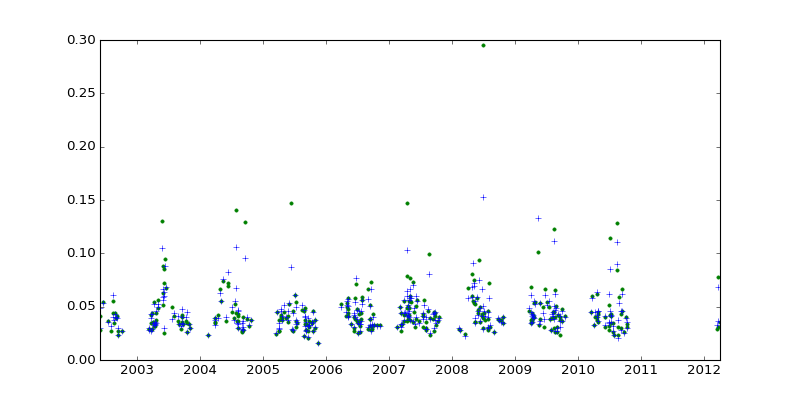

<IPython.core.display.Javascript object>


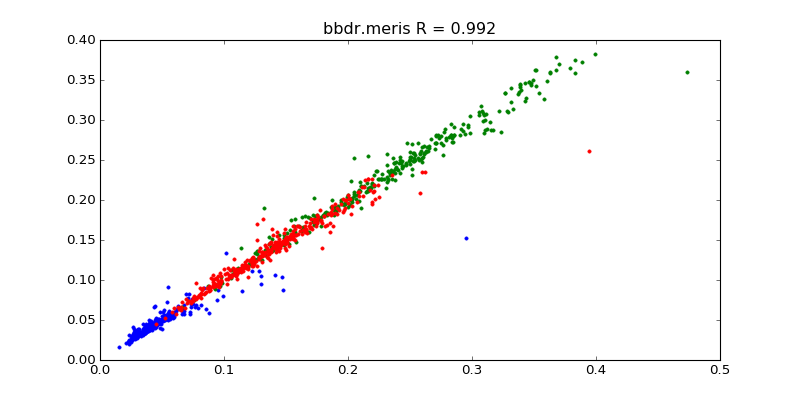

In [75]:
band = 0
m = y_hat[band::nbands] != 0 # many rows in K contain zeros only, hence mask
y_hat_arr = np.array(y_hat)
doys = doys.reshape((doys.size, 1))

t = ncdata[sensor]['idoy']
tt = np.array([timedelta(ti)+d0 for ti in t])

plt.figure(figsize=(10,5))
plt.plot(tt, ncdata[sensor]['refl'][band,:], 'g.')

ttt = np.array([timedelta(ti)+d0 for ti in doys[m] ]) # not same size as tt; several observations can map to one day

plt.plot(ttt, y_hat_arr[band::nbands][m], 'b+')
plt.show()

# scatter plot (multiple same-day observations ignored...)
plt.figure(figsize=(10,5))
bnd = []
x = []
y = []
for band in range(3):
    for i, tti in enumerate(tt):
        if tti in ttt:
            idx = np.where(ttt == tti)[0][0]
            x.append( ncdata[sensor]['refl'][band,i] )
            y.append( y_hat_arr[band::nbands][m][idx])
            bnd.append( band )

x, y, bnd = np.array(x), np.array(y), np.array(bnd)
for band in range(3):
    bln = bnd == band
    plt.plot(x[bln], y[bln], '.')

txt = scipy.stats.linregress(x, y)
plt.title(sensor + ' R = %.3f'%txt[2])


In [72]:
# Set up a matrix K using kernels and dates from ncdata[sensor][...]

# multiply x (estimated state vector) with K to get estimates of y, y_hat

# compute differences between original y in ncdata and y_hat

# repeat the above comparisons, for different A matrices (i.e. different lambdas, regularizations, with or without prior)

# I think the following cell that computes ndays could easily cause a bug. Because the number days between d0 and d1 equals ndays does not mean that using idoy for indexing into A and b gives meaningful results. For indexing into A and b we want an idoy that starts at zero, but given that datasets S3.0 contain fewer observations than S2.0 some of the days at the start of out timeline may have disappeared and hence (idoy*3*3) might exceed the shape/size of A and b.

In [ ]:
d0,d1 = ncdata['bbdr.vgt']['date'][0], ncdata['mod09']['date'][-1]
print 'from', d0, 'to', d1, 'inclusive',
ndays = (d1-d0).days + 1
print 'which gives',ndays,'days'

In [ ]:
print np.all( doys == doys_d )
print doys.shape
print x.shape

In [ ]:
fig = plt.figure(figsize=(15,5))

for start_idx in range(9):
    xi = x[start_idx::9]
    print xi.shape
    plt.plot(doys, xi, '-')
plt.show()

In [ ]:
plt.imshow(A[:5000,:5000].todense())
plt.colorbar()
plt.show()

In [4]:
z = np.array([[1,2,3], [4,5,6],[7,8,9]])

In [5]:
z

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [6]:
Z = np.matrix(z).T

In [7]:
Z

matrix([[1, 4, 7],
        [2, 5, 8],
        [3, 6, 9]])